# Time series forecasting using statistical methods (TP)

Data used: information about onion sales in India.

Goal: predict the sold quantity for Bangalore city.

The data file can be found in the [shared folder](https://drive.google.com/drive/folders/1K7XQBaG4VoYmNdoLZx4bDLXMwWJOwd6S?usp=sharing).

## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.float_format = "{:.2f}".format
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (25, 5)

import warnings
warnings.filterwarnings('ignore')

## Data loading and preprocessing

In [ ]:
data_path = '/content/monthly_market_arrivals.csv'

In [ ]:
data = pd.read_csv(data_path)

# Sort data and define index based on the date column
data.date = pd.DatetimeIndex(data.date)
data = data.sort_values(by="date")
data.index = data.date
# data.index = pd.PeriodIndex(data.date, freq="M")

data.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
1996-01-01,LASALGAON(MS),January,1996,225063,160,257,226,MS,LASALGAON,1996-01-01
1996-02-01,LASALGAON(MS),February,1996,196164,133,229,186,MS,LASALGAON,1996-02-01
1996-03-01,LASALGAON(MS),March,1996,178992,155,274,243,MS,LASALGAON,1996-03-01
1996-04-01,LASALGAON(MS),April,1996,192592,136,279,254,MS,LASALGAON,1996-04-01
1996-05-01,LASALGAON(MS),May,1996,237574,154,312,269,MS,LASALGAON,1996-05-01


Keep only target variable (`quantity`) for Bangalore city.

In [ ]:
ts_data_allvars = data.loc[data.city == "BANGALORE"]
ts_data = ts_data_allvars[['quantity']]
ts_data.head()

,quantity
date,
2004-01-01,227832
2004-02-01,225133
2004-03-01,221952
2004-04-01,185150
2004-05-01,137390


Plot the time series data.

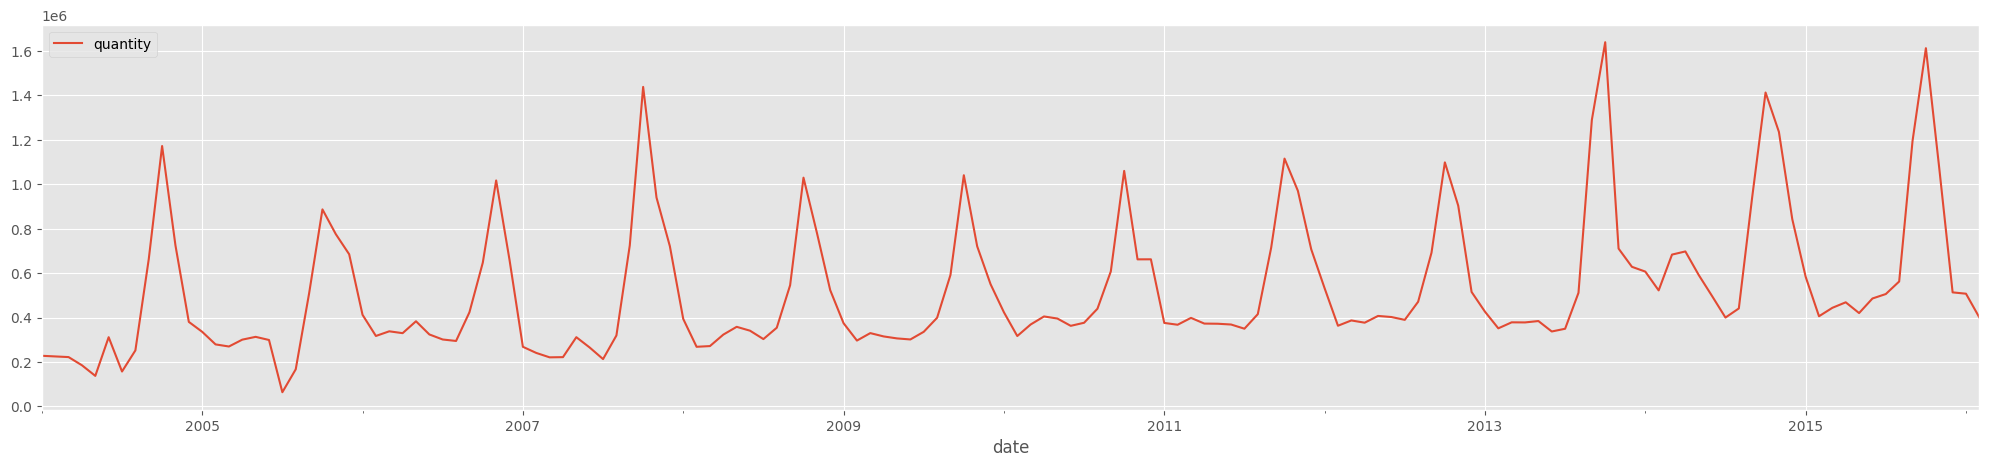

In [ ]:
ts_data.plot();

## Task 1. Check for stationarity

Check the time series for stationarity using Augmented Dickey-Fuller and KPSS tests.

In [ ]:
from statsmodels.tsa import stattools

# Augmented Dickey-Fuller test
def check_adf_stat(ts):

  adf_results = stattools.adfuller(ts)
  adf_stat = adf_results[0]
  p_value = adf_results[1]
  critical_values = adf_results[4]

  print(f'The Augmented Dickey-Fuller test results\
          \n  test statistic {adf_stat:.3f},\
          \n  p-value: {p_value:.3f}\
          \n  critical values: {critical_values}')

  if (p_value > 0.05) or (adf_stat > critical_values['5%']):
    # there is a unit root
    print('The time series is NOT stationary')
  else:
    # there is no unit roots
    print('The time series is stationary')

In [ ]:
# Kwiatkowski–Phillips–Schmidt–Shin test
def check_kpss_stat(ts):

  kpss_results = stattools.kpss(ts)
  kpss_stat = kpss_results[0]
  p_value = kpss_results[1]
  critical_values = kpss_results[3]

  print(f'The KPSS test results\
        \n  test statistic {kpss_stat:.3f},\
        \n  p-value: {p_value:.3f}\
        \n  critical values: {critical_values}')

  if (p_value < 0.05) or (kpss_stat > critical_values['5%']):
      print('The time series is NOT stationary')
  else:
      print('The time series is stationary')

In [ ]:
warnings.filterwarnings('ignore')

check_adf_stat(ts_data)
print("*"*40)
check_kpss_stat(ts_data)

The Augmented Dickey-Fuller test results          
  test statistic -0.878,          
  p-value: 0.795          
  critical values: {'1%': -3.480500383888377, '5%': -2.8835279559405045, '10%': -2.578495716547007}
The time series is NOT stationary
****************************************
The KPSS test results        
  test statistic 0.836,        
  p-value: 0.010        
  critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The time series is NOT stationary


## Task 2. Box Cox transformation

Try the Box Cox transformation and print $\lambda$ found by [boxcox](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) function.

If $\lambda < 0$, assume $\lambda = 0$ and apply a simple logarithmic transformation.

Plot the transformed times series. Is the variance more homogeneous visually?

**Use the transformed time series in the next steps.**

In [ ]:
from scipy.stats import boxcox

boxcox_results = boxcox(ts_data['quantity'])
boxcox_lambda = boxcox_results[1]
print(f'optimal lambda: {boxcox_lambda:.2f}')

optimal lambda: -0.04


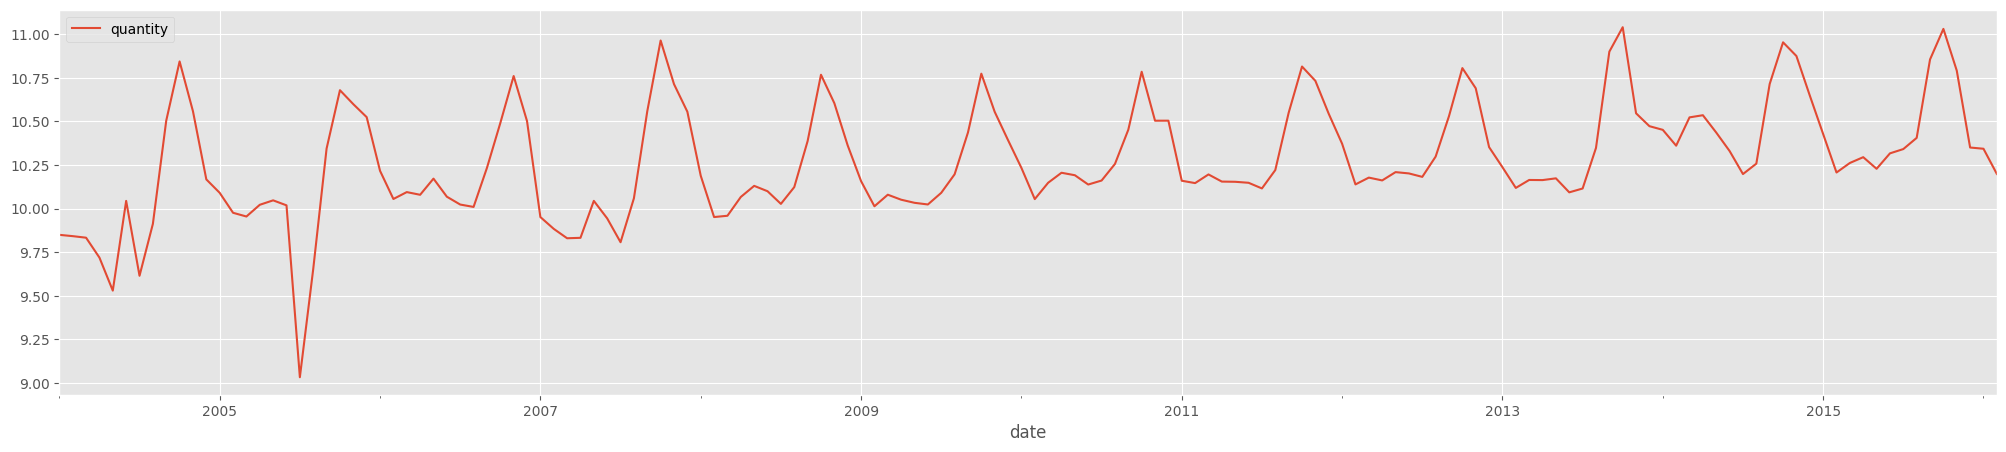

In [ ]:
from copy import deepcopy

ts_boxcox = deepcopy(ts_data)
ts_boxcox['quantity'] = boxcox_results[0]
ts_boxcox.plot();

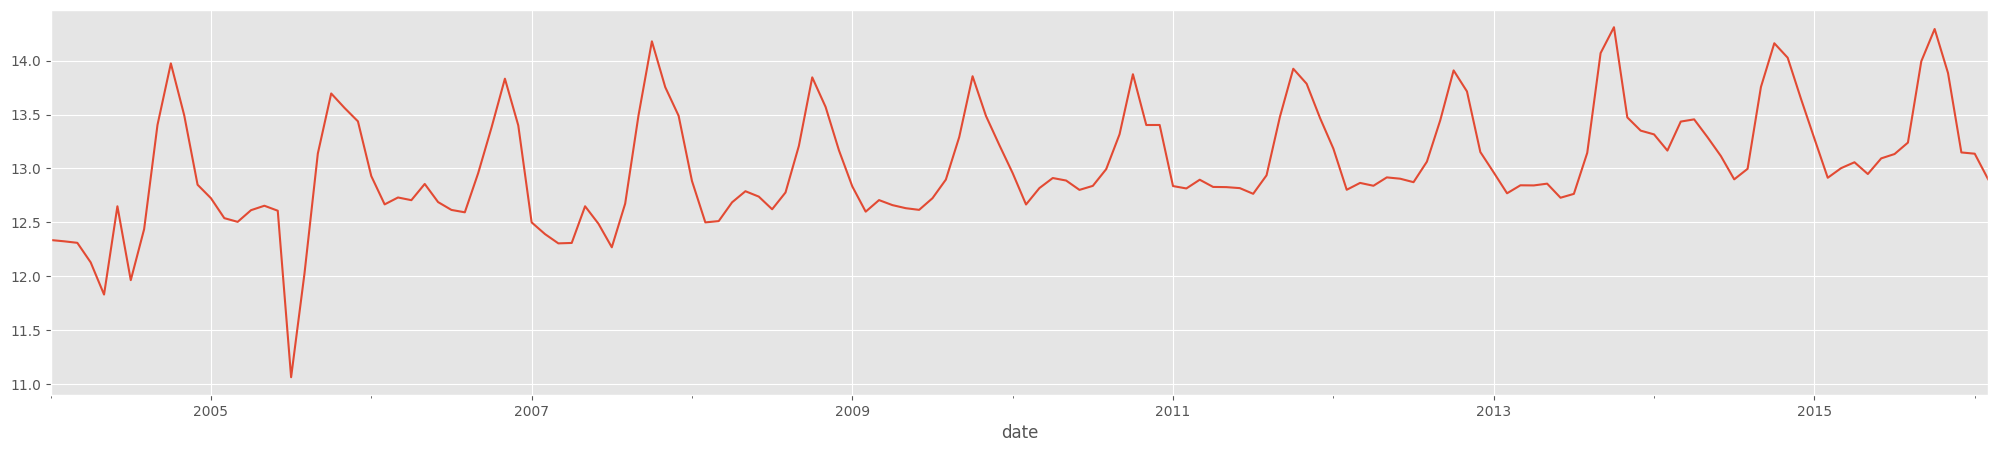

In [ ]:
ts_data = np.log(ts_data['quantity'])
ts_data.plot();

## Task 3. Differencing

There is a slight increasing trend in the series. Apply differencing to it.

Has the time series become stationary?

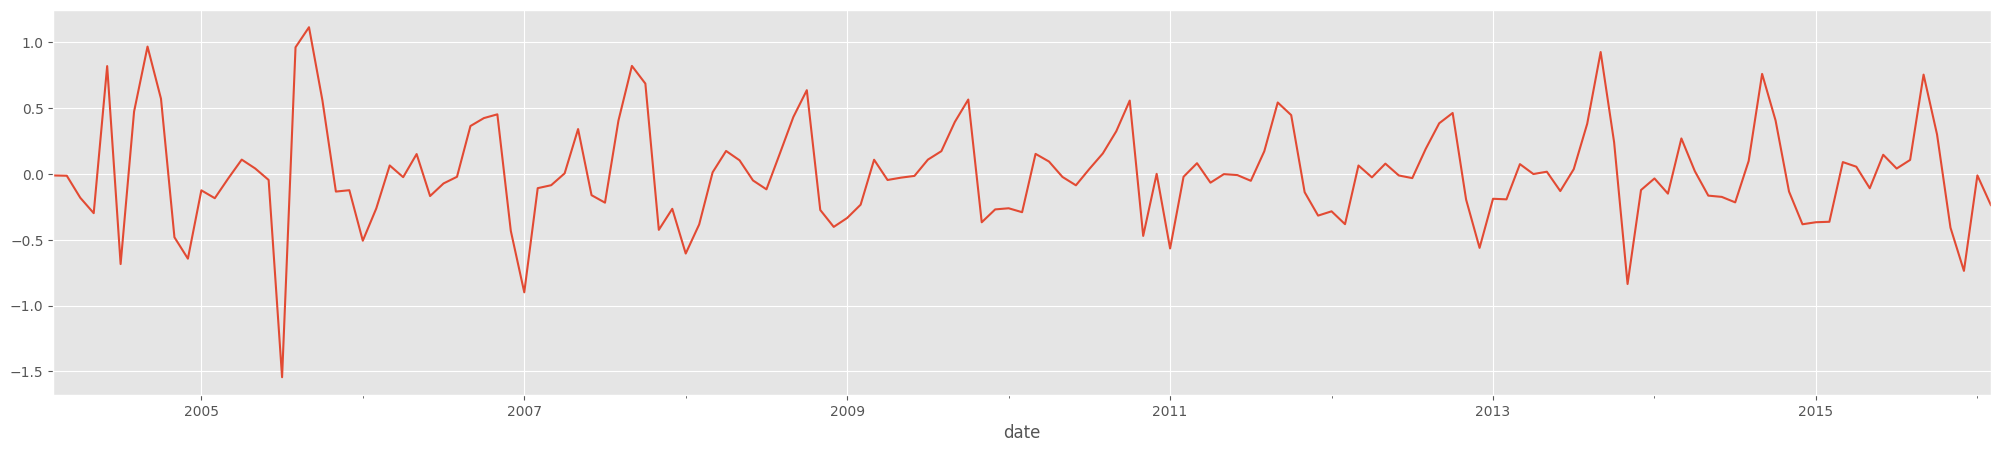

In [ ]:
ts_diff = (ts_data - ts_data.shift(1))[1:]
ts_diff.plot();

In [ ]:
warnings.filterwarnings('ignore')

check_adf_stat(ts_diff)
print("*"*40)
check_kpss_stat(ts_diff)

The Augmented Dickey-Fuller test results          
  test statistic -6.729,          
  p-value: 0.000          
  critical values: {'1%': -3.4808880719210005, '5%': -2.8836966192225284, '10%': -2.5785857598714417}
The time series is stationary
****************************************
The KPSS test results        
  test statistic 0.074,        
  p-value: 0.100        
  critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The time series is stationary


## Task 4. Identifying ARIMA hyperparameters

Identify $p$ and $q$ values for ARIMA (SARIMAX) using ACF and PACF plots.

The value ranges for these parameters include all values from 0 to the lag corresponded to the last significant value within the period (the lag of the period itself is not taken into account).

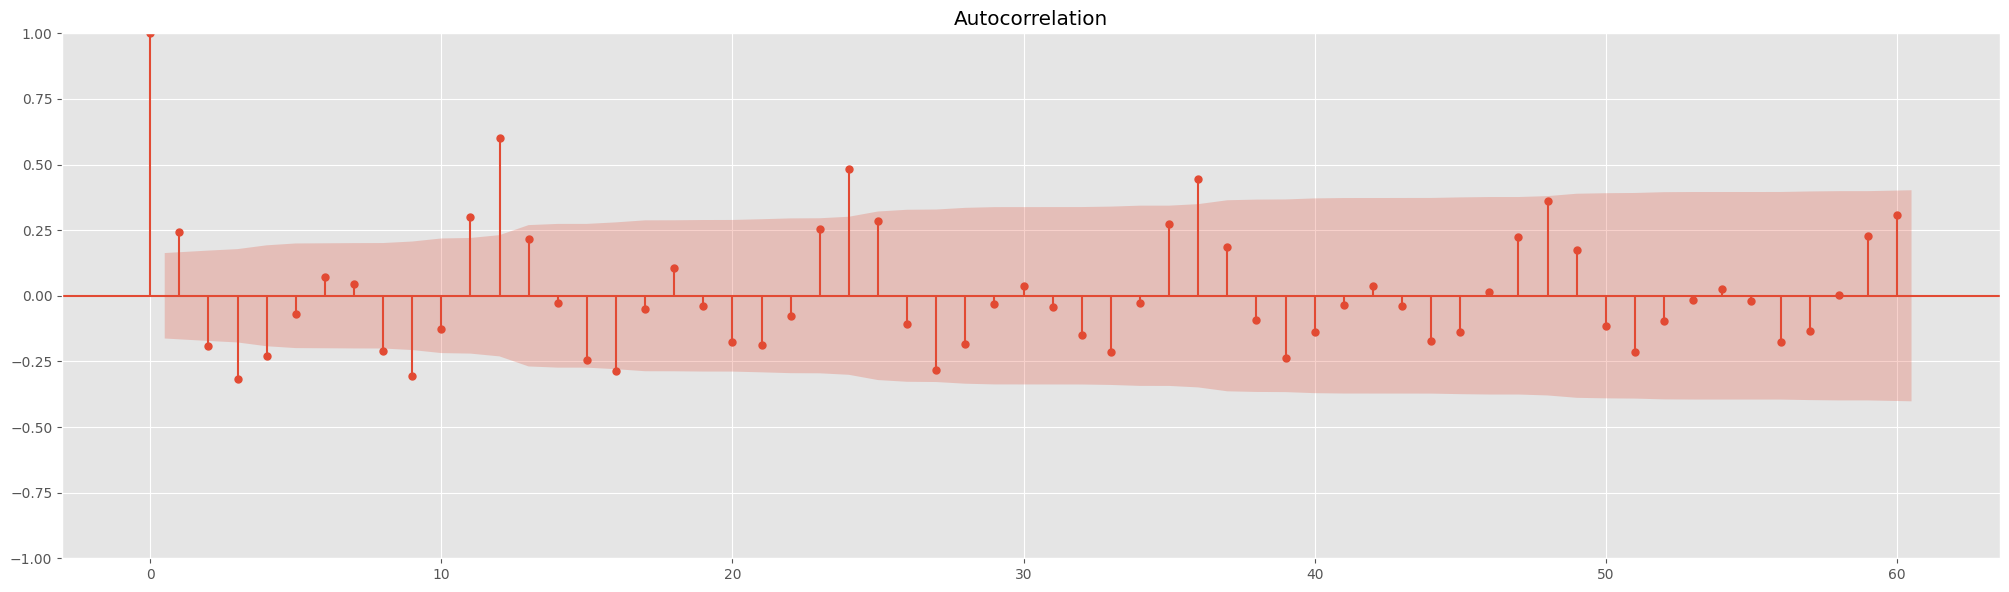

In [ ]:
import statsmodels.graphics.tsaplots as tsaplots

fig = plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_acf(ts_diff, lags=60, ax=ax1);

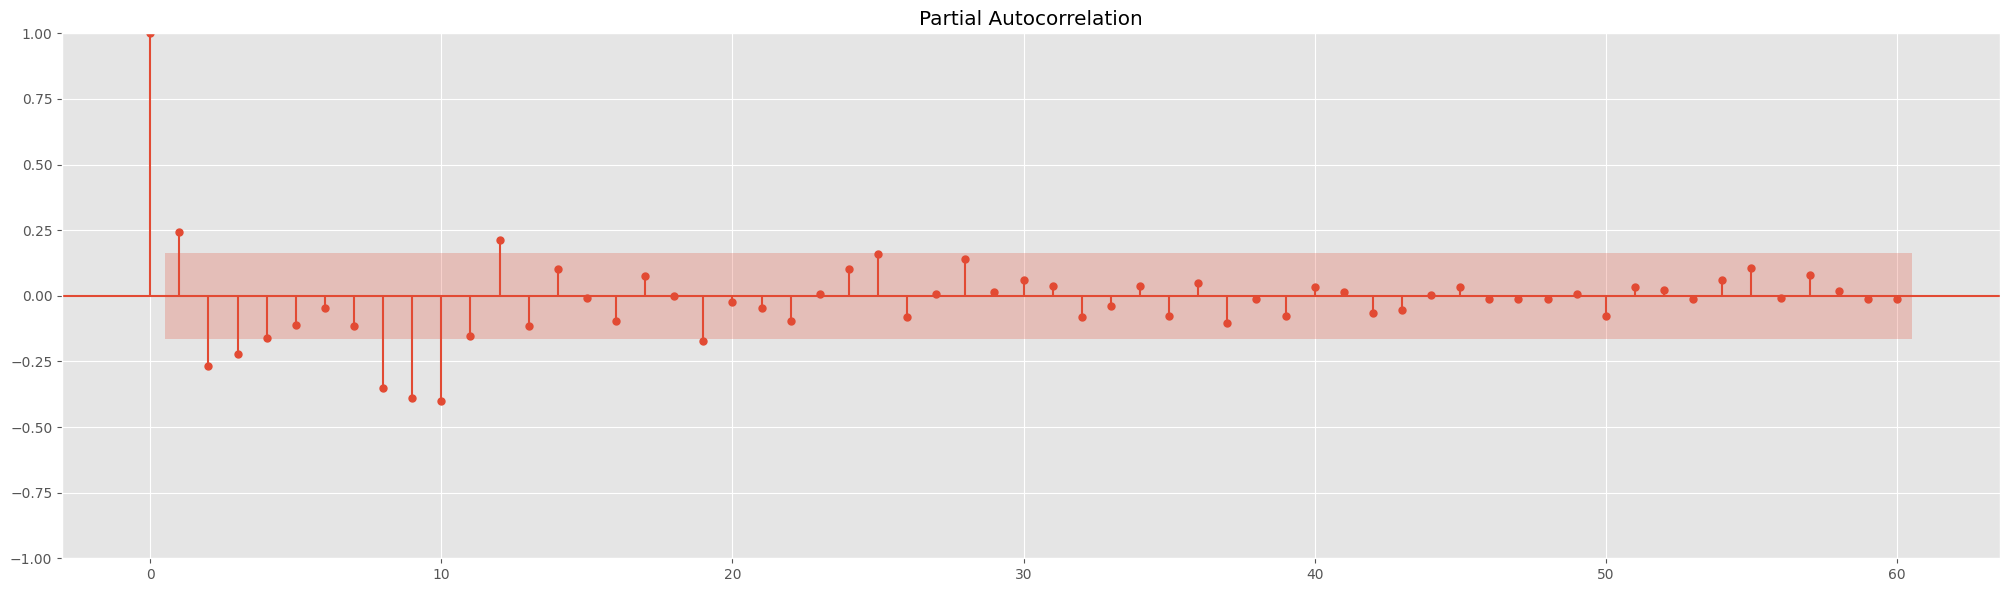

In [ ]:
fig = plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_pacf(ts_diff, lags=60, ax=ax1)

## Task 5. Split data into train, val, and test sets.

In the next steps you will use SARIMAX model, therefore you will need to use initial data (non transformed using differencing, Box Cox, etc.).

Split data into train, val, and test sets.

* train - first 65% of data
* val - next 20% of data
* test - last 15% of data

Check the shape of each set and display them on a single plot.

In [ ]:
len_train = int(len(ts_data) * 0.65)
len_val = int(len(ts_data) * 0.2)
ind_split_1 = len_train
ind_split_2 = len_train + len_val

ts_train = ts_data[:ind_split_1]
ts_val = ts_data[ind_split_1:ind_split_2]
ts_test = ts_data[ind_split_2:]

ts_data.shape, ts_train.shape, ts_val.shape, ts_test.shape

((146,), (94,), (29,), (23,))

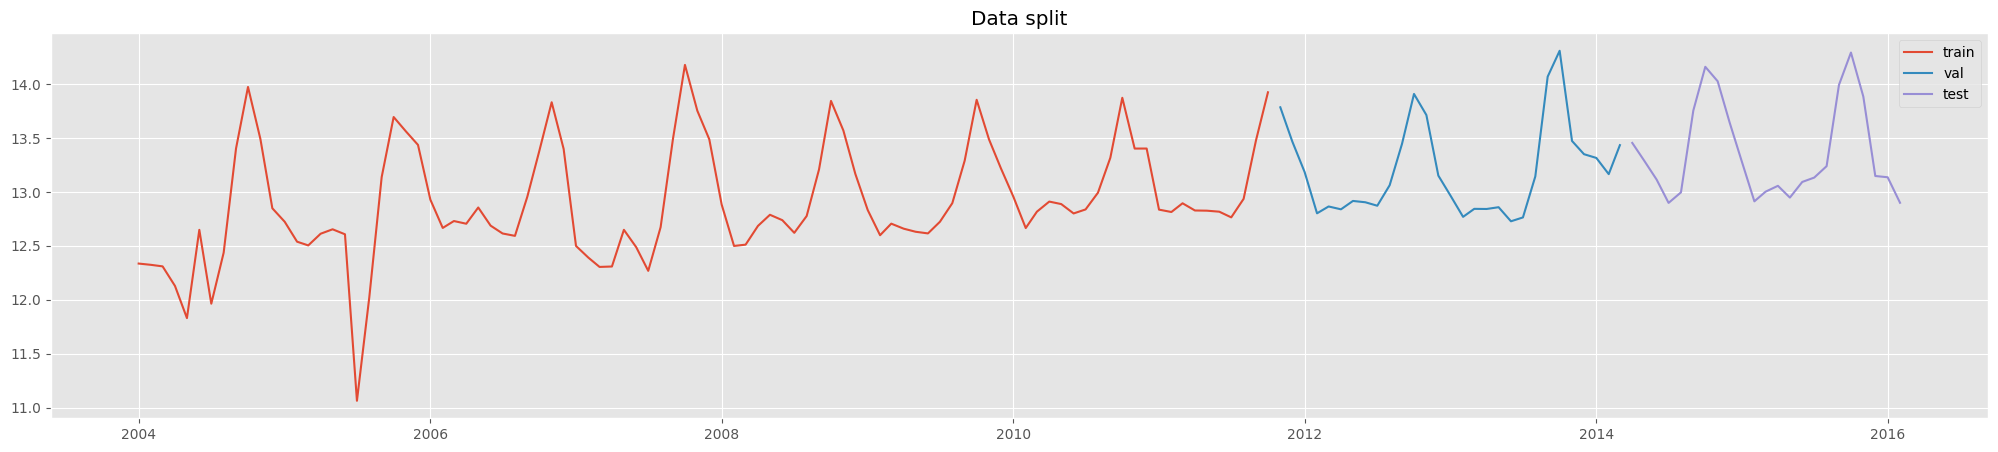

In [ ]:
plt.figure()
plt.plot(ts_train.index, ts_train.values, label='train')
plt.plot(ts_val.index, ts_val.values, label='val')
plt.plot(ts_test.index, ts_test.values, label='test')
plt.legend(loc='best')
plt.title('Data split')
plt.show()

## Task 6. Tuning ARIMA hyperparameters of SARIMAX

In step 4, you identified the ranges for $p$ and $q$. In step 3 you saw that a single differencing ($d=1)$ transformed the times series into a stationary one. $d=0$ can be also considered.

To tune $(p,d,q)$ hyperparameters, you will use `SARIMAX` model and `AIC` metric. Using nested loops, find the values for $(p,d,q)$ corresponding to the minimum `AIC`.

Try using RMSE to tune $(p,d,q)$ hyperparameters.

In [ ]:
p_values = range(0,12)
q_values = range(0,12)
d_values = range(0,2)
# d_values = range(1,2)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings('ignore')

best_score_aic, best_cfg_aic = float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                model = SARIMAX(ts_train, order=order).fit()
                if model.aic < best_score_aic:
                    best_score_aic, best_cfg_aic = model.aic, order
                    print(f'SARIMAX{order} AIC={model.aic:.3f}')
            except:
                continue

print(f'Best SARIMAX{best_cfg_aic} AIC={best_score_aic:.3f}')

SARIMAX(0, 0, 0) AIC=749.566
SARIMAX(0, 0, 1) AIC=627.876
SARIMAX(0, 0, 2) AIC=520.888
SARIMAX(0, 0, 3) AIC=431.815
SARIMAX(0, 0, 4) AIC=378.255
SARIMAX(0, 0, 5) AIC=321.986
SARIMAX(0, 0, 6) AIC=292.977
SARIMAX(0, 0, 7) AIC=259.232
SARIMAX(0, 0, 8) AIC=245.066
SARIMAX(0, 0, 9) AIC=242.442
SARIMAX(0, 0, 10) AIC=207.395
SARIMAX(0, 0, 11) AIC=206.898
SARIMAX(0, 1, 0) AIC=102.548
SARIMAX(0, 1, 1) AIC=99.458
SARIMAX(0, 1, 3) AIC=81.951
SARIMAX(0, 1, 6) AIC=81.139
SARIMAX(0, 1, 7) AIC=65.710
SARIMAX(2, 1, 9) AIC=62.166
SARIMAX(3, 1, 11) AIC=61.634
SARIMAX(4, 1, 9) AIC=59.632
SARIMAX(5, 1, 11) AIC=58.876
SARIMAX(6, 1, 6) AIC=53.695
SARIMAX(6, 1, 8) AIC=45.491
SARIMAX(6, 1, 9) AIC=39.725
SARIMAX(8, 1, 11) AIC=39.061
SARIMAX(11, 1, 3) AIC=38.390
Best SARIMAX(11, 1, 3) AIC=38.390


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

best_score_rmse, best_cfg_rmse = float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                model = SARIMAX(ts_train, order=order).fit()
                ts_pred = model.predict(start=ts_val.index[0], end=ts_val.index[-1])
                rmse = mean_squared_error(ts_val.values, ts_pred.values, squared=False)

                if rmse < best_score_rmse:
                    best_score_rmse, best_cfg_rmse = rmse, order
                    print(f'SARIMAX{order} RMSE={rmse:.3f}')
            except:
                continue

print(f'Best SARIMAX{best_cfg_rmse} RMSE={best_score_rmse:.3f}')

SARIMAX(0, 0, 0) RMSE=13.212
SARIMAX(0, 0, 1) RMSE=13.007
SARIMAX(0, 0, 2) RMSE=12.904
SARIMAX(0, 0, 3) RMSE=12.673
SARIMAX(0, 0, 5) RMSE=12.411
SARIMAX(0, 0, 6) RMSE=12.385
SARIMAX(0, 0, 7) RMSE=12.156
SARIMAX(0, 0, 8) RMSE=12.005
SARIMAX(0, 0, 9) RMSE=11.909
SARIMAX(0, 0, 10) RMSE=11.595
SARIMAX(0, 0, 11) RMSE=11.587
SARIMAX(0, 1, 0) RMSE=0.833
SARIMAX(0, 1, 2) RMSE=0.769
SARIMAX(0, 1, 3) RMSE=0.424
SARIMAX(0, 1, 6) RMSE=0.413
SARIMAX(0, 1, 7) RMSE=0.391
SARIMAX(1, 1, 6) RMSE=0.390
SARIMAX(2, 1, 2) RMSE=0.346
SARIMAX(3, 1, 9) RMSE=0.323
SARIMAX(4, 1, 9) RMSE=0.293
SARIMAX(6, 1, 9) RMSE=0.280
SARIMAX(7, 1, 8) RMSE=0.259
SARIMAX(7, 1, 10) RMSE=0.253
SARIMAX(8, 1, 2) RMSE=0.243
SARIMAX(8, 1, 5) RMSE=0.235
SARIMAX(10, 1, 0) RMSE=0.232
Best SARIMAX(10, 1, 0) RMSE=0.232


## Task 7. Making predictions

Fit SARIMAX model on the union of **train** and **val** sets using the best values of $(p,d,q)$ found on the previous step. Produce forecasts on **test** set.

Plot train (train and val) and test data among with the forecasts for the test period.

Calculate the RMSE score on test data. Display it in the plot title.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

ts_train_val = pd.concat([ts_train,ts_val], axis=0)
best_order = (11, 1, 3)
model_sarimax = SARIMAX(ts_train_val, order=best_order).fit()
ts_pred = model_sarimax.predict(start=ts_test.index[0], end=ts_test.index[-1])
rmse = mean_squared_error(ts_test.values, ts_pred.values, squared=False)
print(f'SARIMAX{best_order}\nAIC={model_sarimax.aic:.2f}\nRMSE (test)={rmse:.2f}')

SARIMAX(11, 1, 3)
AIC=29.40
RMSE (test)=0.30


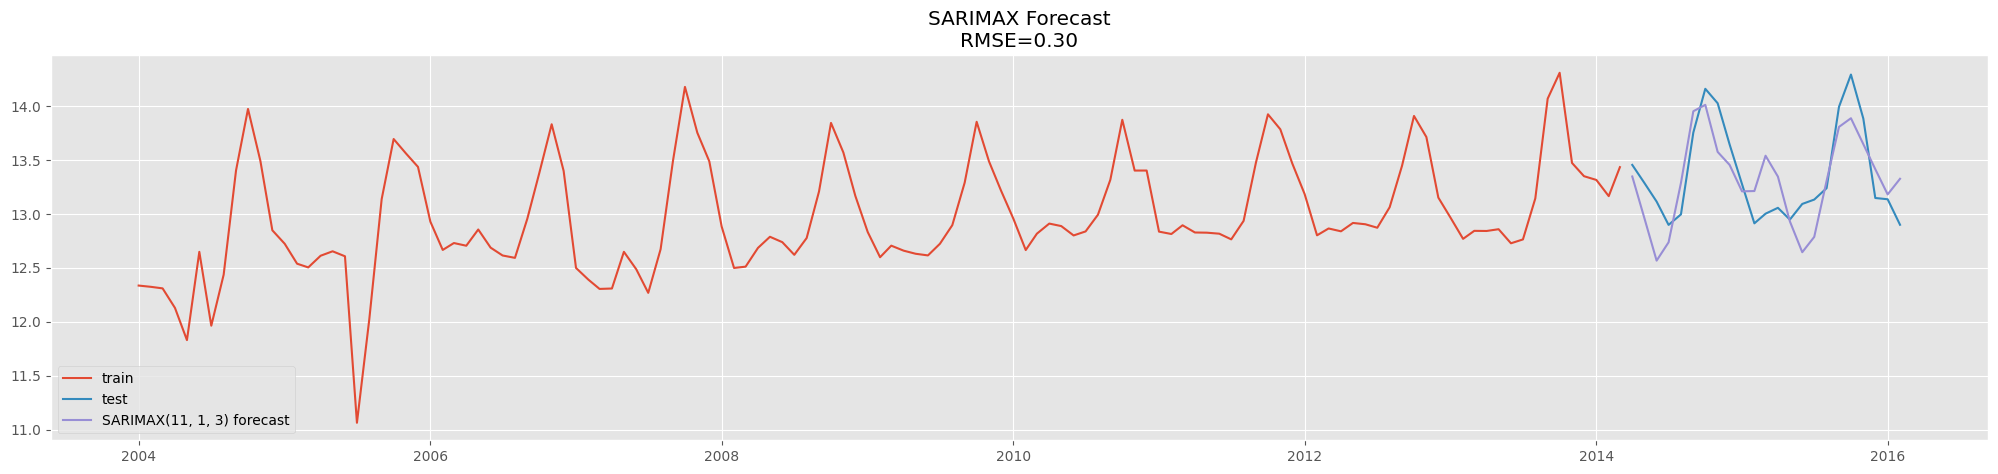

In [ ]:
plt.figure()
plt.plot(ts_train_val.index, ts_train_val.values, label='train')
plt.plot(ts_test.index, ts_test.values, label='test')
plt.plot(ts_pred.index, ts_pred.values, label=f'SARIMAX{best_order} forecast')
plt.legend(loc='best')
plt.title(f'SARIMAX Forecast\nRMSE={rmse:.2f}')
plt.show()

## Task 8. Tuning seasonal parameters of SARIMAX


Using ACF and PACF, detect the approximate ranges for $P$ and $Q$. Include $0$ to the ranges. Determine $s$.

Find the best combination $(P,D,Q)$:
*   Use SARIMAX model and AIC metric.
*   Use $(p,d,q)$ found in the step 6.
*   Try $D=0$ and $D=1$.



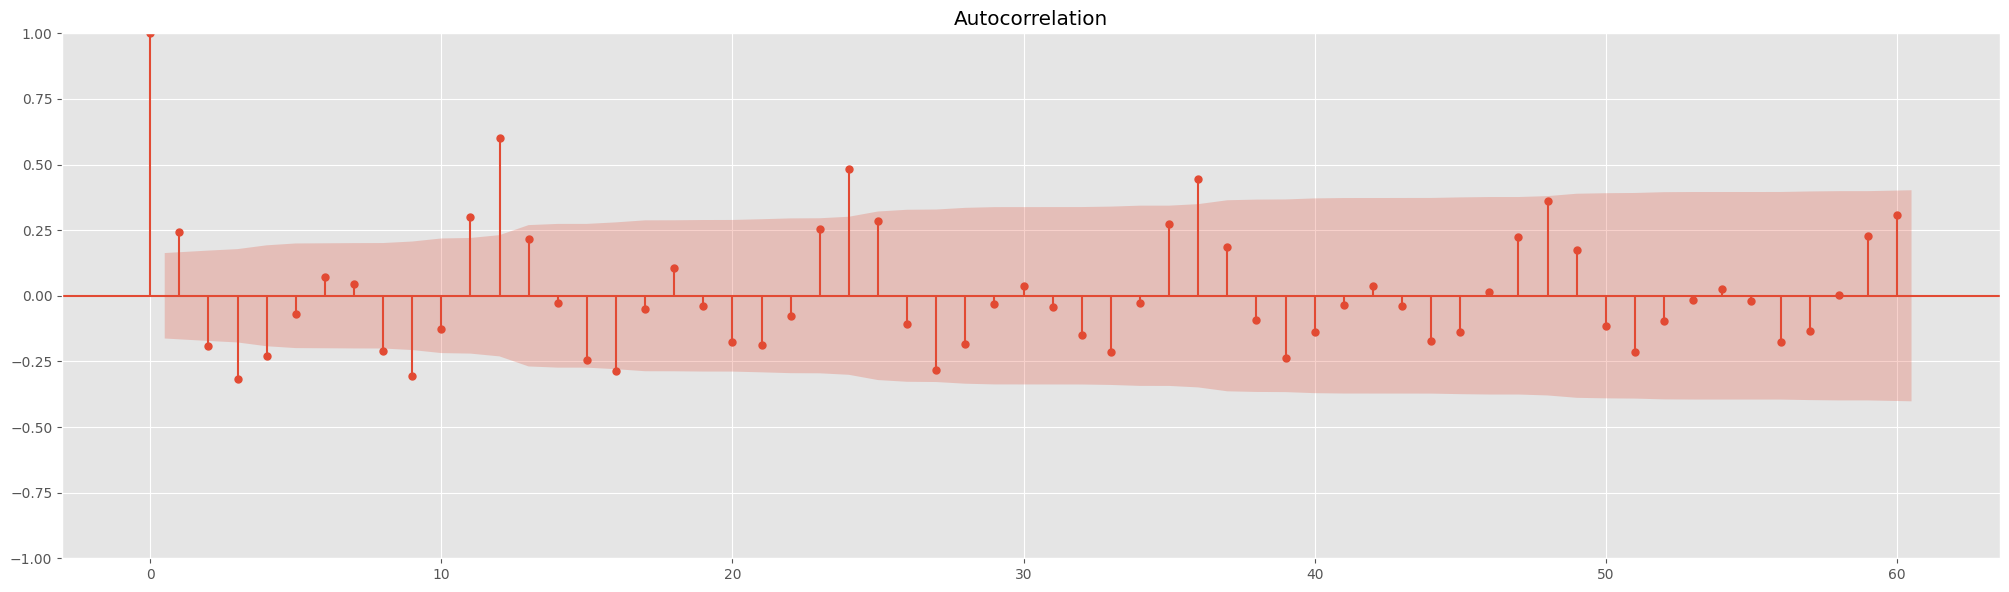

In [ ]:
import statsmodels.graphics.tsaplots as tsaplots

fig = plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_acf(ts_diff, lags=60, ax=ax1);

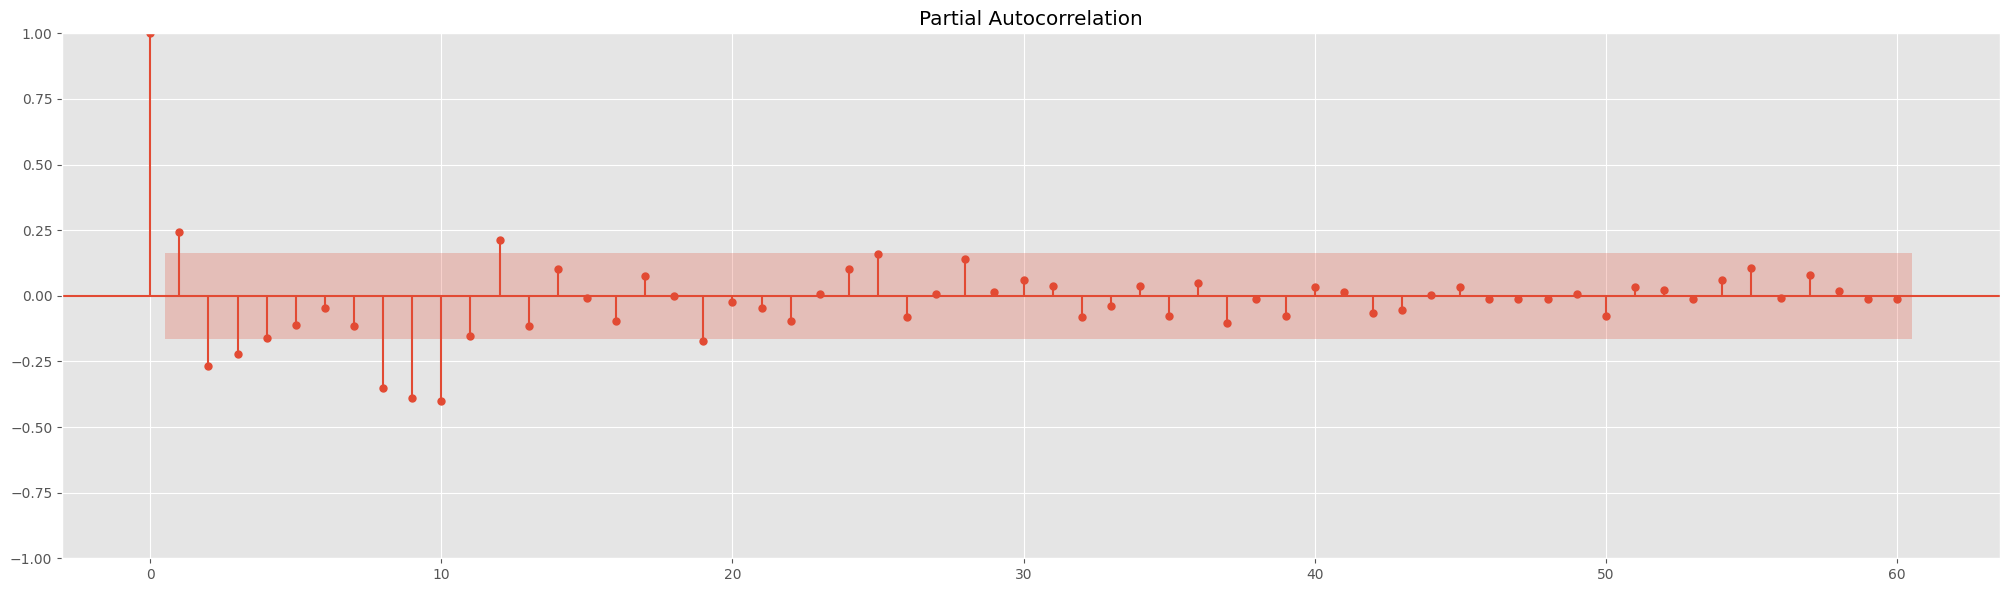

In [ ]:
fig = plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_pacf(ts_diff, lags=60, ax=ax1)

In [ ]:
P_values = range(0,2)
Q_values = range(0,4)
D_values = range(0,2)
s = 12

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (11, 1, 3)
best_score_aic, best_cfg_aic = float("inf"), None

for P in P_values:
    for D in D_values:
        for Q in Q_values:
            seasonal_order=(P, D, Q, s)
            try:
                model = SARIMAX(ts_train, order=order, seasonal_order=seasonal_order).fit()
                if model.aic < best_score_aic:
                    best_score_aic, best_cfg_aic = model.aic, seasonal_order
                    print(f'SARIMAX{order}{seasonal_order} AIC={model.aic:.3f}')
            except:
                continue

print(f'Best SARIMAX{order}{best_cfg_aic} AIC={best_score_aic:.3f}')

SARIMAX(11, 1, 3)(0, 0, 0, 12) AIC=38.390
SARIMAX(11, 1, 3)(0, 1, 1, 12) AIC=23.623
Best SARIMAX(11, 1, 3)(0, 1, 1, 12) AIC=23.623


## Task 9. Making predictions

Fit SARIMAX model on the union of **train** and **val** sets using the best values of $order=(p,d,q)$ and $seasonal\_order=(P,D,Q,s)$ found on the previous steps. Produce forecasts on **test** set.

Plot train (train and val) and test data among with the forecasts for the test period.

Calculate the RMSE score on test data. Display it in the plot title.

**Does the SARIMAX model based on the tuned ARIMA and seasonal parameters make good forecasts?**

In [ ]:
from sklearn.metrics import mean_squared_error

ts_train_val = pd.concat([ts_train,ts_val], axis=0)
order = (11, 1, 3)
seasonal_order = (0, 1, 1, 12)
model_sarimax = SARIMAX(ts_train_val, order=order, seasonal_order=seasonal_order).fit()
ts_pred = model_sarimax.predict(start=ts_test.index[0], end=ts_test.index[-1])
rmse = mean_squared_error(ts_test.values, ts_pred.values, squared=False)
print(f'SARIMAX{order}{seasonal_order}\nAIC={model_sarimax.aic:.2f}\nRMSE (test)={rmse:.2f}')

SARIMAX(11, 1, 3)(0, 1, 1, 12)
AIC=8.75
RMSE (test)=0.22


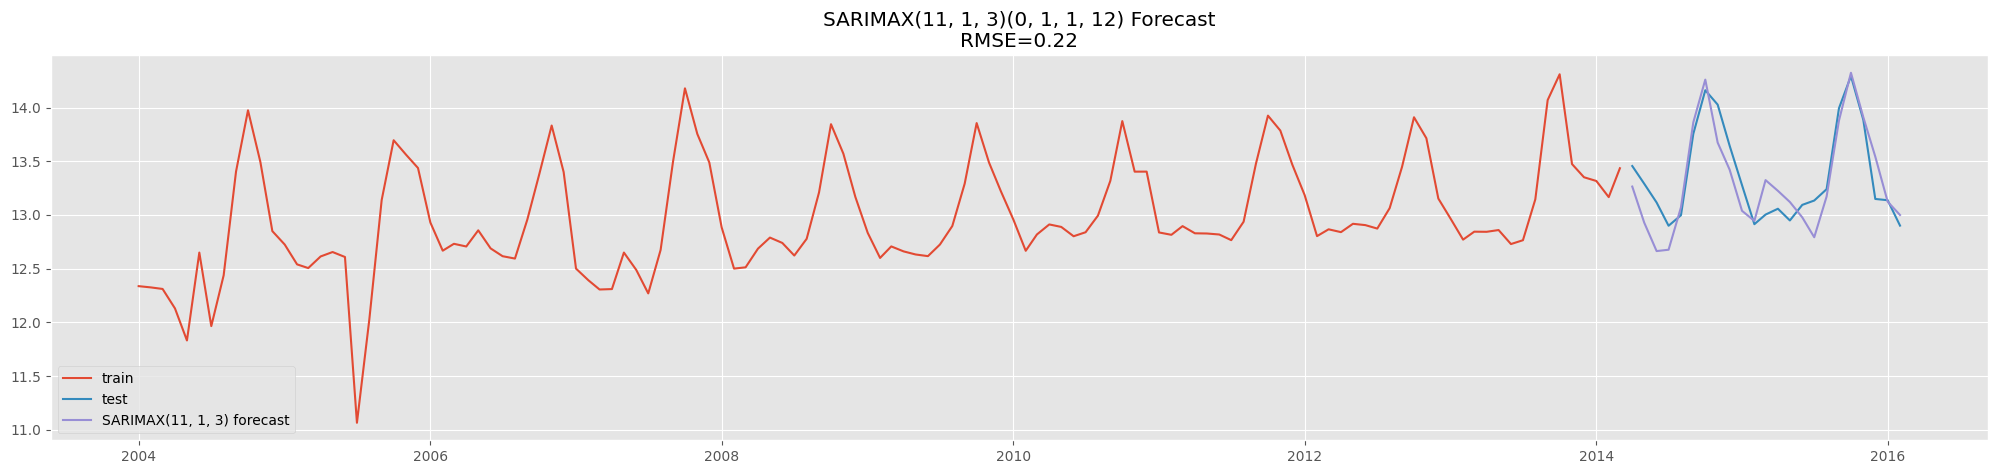

In [ ]:
plt.figure()
plt.plot(ts_train_val.index, ts_train_val.values, label='train')
plt.plot(ts_test.index, ts_test.values, label='test')
plt.plot(ts_pred.index, ts_pred.values, label=f'SARIMAX{best_order} forecast')
plt.legend(loc='best')
plt.title(f'SARIMAX{order}{seasonal_order} Forecast\nRMSE={rmse:.2f}')
plt.show()

## Task 10. Model improvement

Try exogeneous parameters, like `priceMod` (see `exog` parameter of `SARIMAX` function).

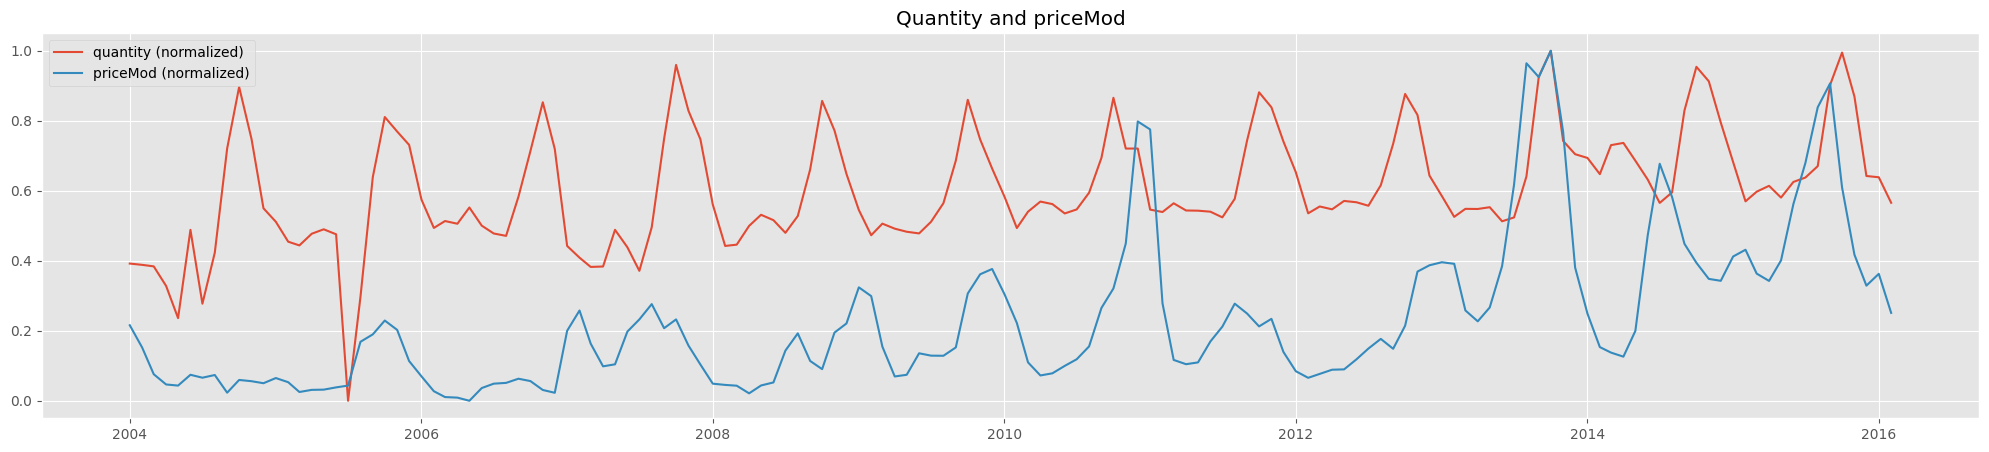

In [ ]:
from sklearn.preprocessing import MinMaxScaler

ts_priceMod = ts_data_allvars[['priceMod']]

priceMod_normalized = MinMaxScaler(feature_range=(0, 1)).fit_transform(ts_priceMod.values.reshape(-1, 1))
quantity_normalized = MinMaxScaler(feature_range=(0, 1)).fit_transform(ts_data.values.reshape(-1, 1))

plt.figure()
plt.plot(ts_data.index, quantity_normalized, label='quantity (normalized)')
plt.plot(ts_priceMod.index, priceMod_normalized, label='priceMod (normalized)')
plt.legend(loc='best')
plt.title('Quantity and priceMod')
plt.show()

In [ ]:
ts_train_priceMod = ts_priceMod[:ind_split_1]
ts_val_priceMod = ts_priceMod[ind_split_1:ind_split_2]
ts_test_priceMod = ts_priceMod[ind_split_2:]

ts_train_val = pd.concat([ts_train,ts_val], axis=0)
ts_train_val_priceMod = pd.concat([ts_train_priceMod,ts_val_priceMod], axis=0)

In [ ]:
order = (11, 1, 3)
seasonal_order = (0, 1, 1, 12)
model_sarimax_exog = SARIMAX(ts_train_val, exog=ts_train_val_priceMod, order=order, seasonal_order=seasonal_order).fit()
ts_pred_exog = model_sarimax_exog.predict(start=ts_test.index[0], end=ts_test.index[-1], exog=ts_test_priceMod)
rmse = mean_squared_error(ts_test.values, ts_pred_exog.values, squared=False)
print(f'SARIMAX{order}{seasonal_order}\nAIC={model_sarimax_exog.aic:.2f}\nRMSE (test)={rmse:.2f}')

SARIMAX(11, 1, 3)(0, 1, 1, 12)
AIC=31.32
RMSE (test)=0.29


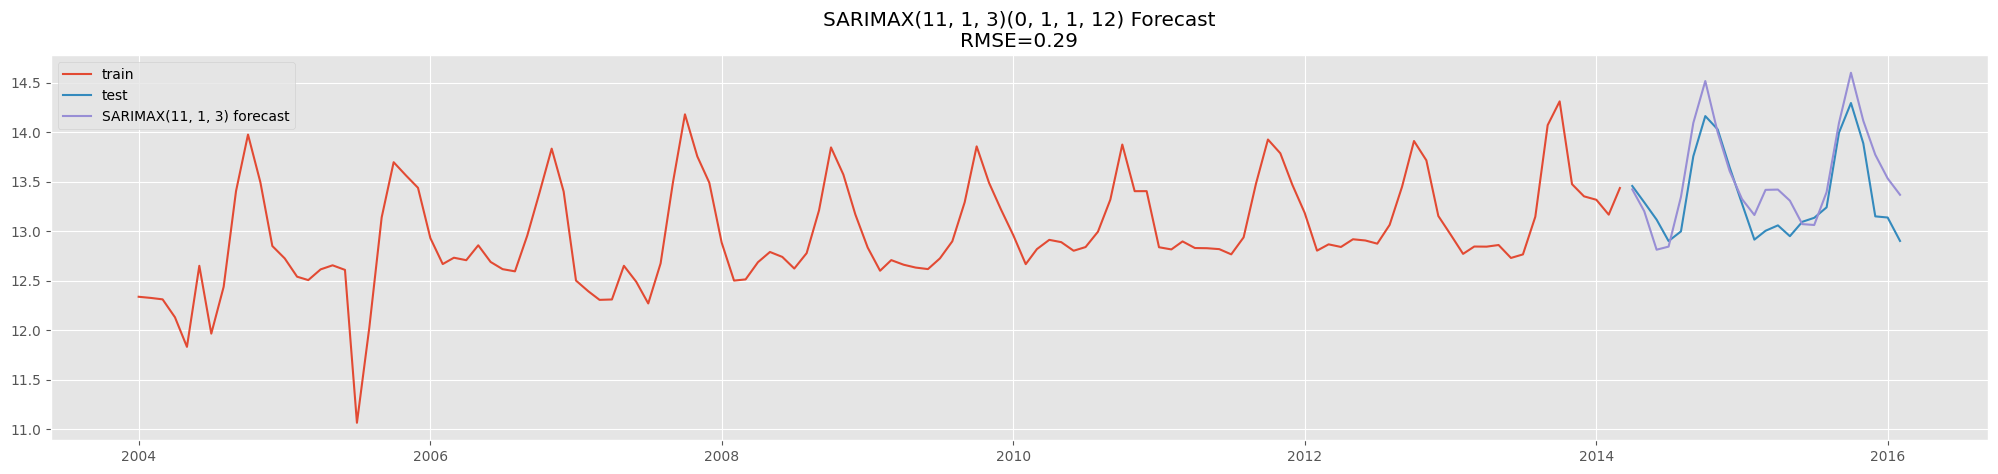

In [ ]:
plt.figure()
plt.plot(ts_train_val.index, ts_train_val.values, label='train')
plt.plot(ts_test.index, ts_test.values, label='test')
plt.plot(ts_pred_exog.index, ts_pred_exog.values, label=f'SARIMAX{best_order} forecast')
plt.legend(loc='best')
plt.title(f'SARIMAX{order}{seasonal_order} Forecast\nRMSE={rmse:.2f}')
plt.show()

## Residual analysis

The **residuals** of a model are the difference between the predicted values and the actual values.

A good model has residuals that are similar to white noise, so the **residuals should be normally distributed and uncorrelated**.

### Quantile-quantile (Q-Q) plot

**Qualitative analysis**: is the residuals distribution is close to the normal one?

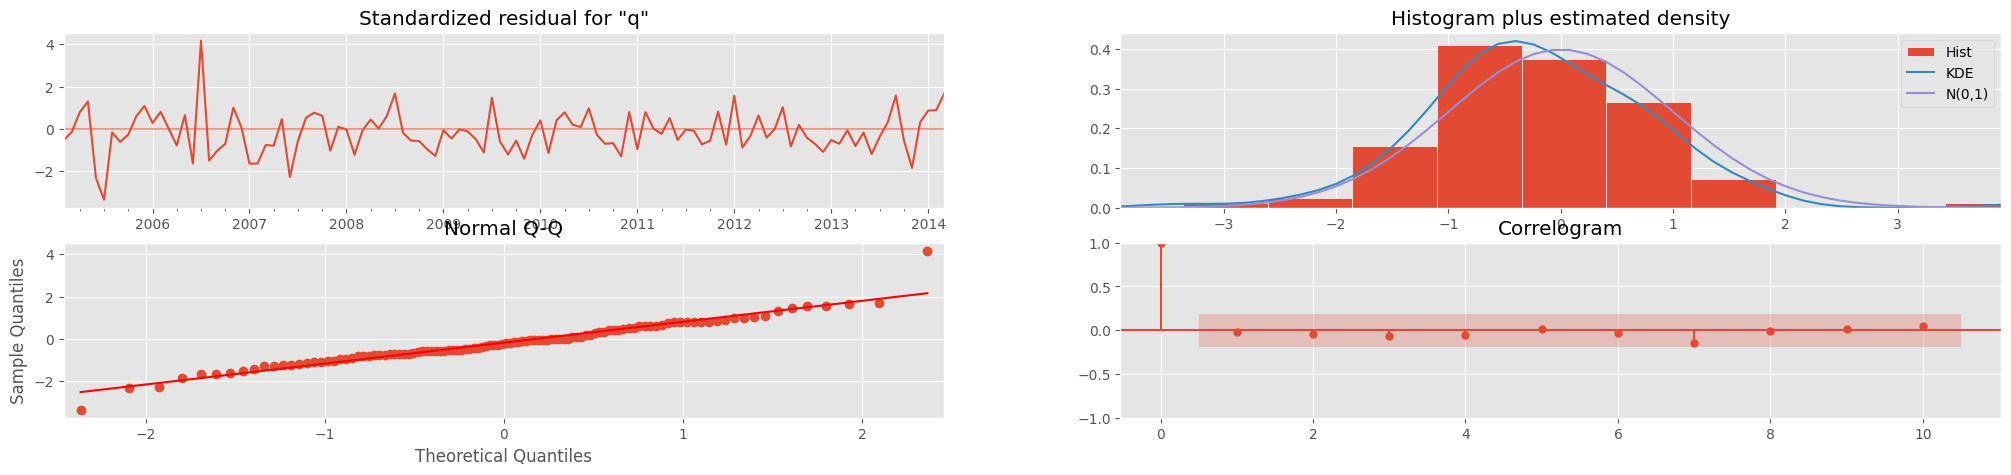

In [ ]:
# from statsmodels.graphics.gofplots import qqplot

residuals = model_sarimax.resid
# qqplot(residuals, line='45');
model_sarimax.plot_diagnostics();

The distribution of the residuals is close to a normal distribution.

### Ljung-Box test

**Quantitative analysis**: are the residuals
uncorrelated?

The Ljung-Box test is a statistical test that determines whether the
autocorrelation of a group of data is significantly different from 0.

The **null hypothesis**: the data is independently distributed (**no autocorrelation**)

*   If $𝑝\_𝑣𝑎𝑙𝑢𝑒>0.05$, we cannot reject the null hypothesis: the residuals are independently distributed, and the model can be used for forecasting.

*   Otherwise, the model shouldn't be used for forecasting.

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(residuals, lags=np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.09,0.77
2,0.11,0.95
3,0.30,0.96
4,0.76,0.94
5,1.15,0.95
6,1.15,0.98
7,1.17,0.99
8,1.99,0.98
9,2.21,0.99
10,2.39,0.99


There is no autocorrelation.